# Section 1: Simple RAG with LangGraph

![Simple RAG](../images/simple_rag.png)

In this first notebook, we're going to set up a simple RAG workflow while introducing several LangGraph concepts.

We're then going to step into LangSmith and LangGraph Studio to see how they can improve the AI developer experience.

## Setup

You can install the required packages directly to this notebook environment if you cannot use virtual environments for some reason.

In [ ]:
required_packages = [
    "langgraph", 
    "langgraph-sdk", 
    "langgraph-checkpoint-sqlite", 
    "langsmith", 
    "langchain-community", 
    "langchain-core", 
    "langchain-openai", 
    "notebook", 
    "python-dotenv", 
    "chromadb"
]

# Install each package
for package in required_packages:
    %pip install {package}

You can also set your environment variables locally in this notebook.

In [2]:
import os

# Set environment variables
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-101"

In [1]:
# Alternatively, load environment variables from .env
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env", override=True)

True

Make sure you've followed the instructions in setup.md if you haven't yet!

Let's confirm that LangSmith tracing is enabled. If for some reason you can't see traces showing up in LangSmith, this is a great helper command to make sure you can trace!

In [2]:
import os
from langsmith import utils

os.environ.get("LANGCHAIN_TRACING_V2")
utils.tracing_is_enabled()

True

Because we're building a RAG application, we're going to create a vector database. The function for this is in utils.py in the studio folder, feel free to take a look if you're curious! We're going to go ahead and index some LangGraph documentation, in reality you can choose any documents you want, and hook up to your production vector store.

In [3]:
from utils import get_vector_db_retriever

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from azure.identity import InteractiveBrowserCredential

credential = InteractiveBrowserCredential()

def get_token():
    token = credential.get_token("https://cognitiveservices.azure.com/.default")
    return token.token

RAG_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.

Question: {question} 
Context: {context} 
Answer:"""

RAG_PROMPT_WITH_MESSAGES = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
The pre-existing conversation may provide important context to the question.
Use three sentences maximum and keep the answer concise.

Conversation: {conversation}
Context: {context} 
Answer:"""

# SiteMap loader
LANGGRAPH_DOCS = [
    "https://langchain-ai.github.io/langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/",
    "https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/"
]

def get_vector_db_retriever():
    # Set embeddings
    # embd = AzureOpenAIEmbeddings(
    #     openai_api_version="2024-03-01-preview",
    #     azure_endpoint="https://deployment.openai.azure.com/",
    #     model="text-embedding-3-large",
    #     azure_ad_token_provider=get_token
    # )
    embd = OpenAIEmbeddings()
    # Docs to index
    urls = LANGGRAPH_DOCS
    # Load
    docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]
    # Split
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=200, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(docs_list)
    # Add to vectorstore
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=embd,
    )
    retriever = vectorstore.as_retriever(lambda_mult=0)
    return retriever

In [6]:
retriever = get_vector_db_retriever()

## Basic RAG

### Chat Models and Messages

In this course, we'll be using [Chat Models](https://python.langchain.com/v0.2/docs/concepts/#chat-models), which take a sequence of messages as inputs and return chat messages as outputs. LangChain does not host any Chat Models, rather we rely on third party integrations. [Here](https://python.langchain.com/v0.2/docs/integrations/chat/) is a list of 3rd party chat model integrations within LangChain! By default, the course with use [ChatOpenAI](https://python.langchain.com/v0.2/docs/integrations/chat/openai/) because it is both popular and performant.

Let's instantiate a Chat Model using ChatOpenAI! We use gpt-4o because it is a good balance of speed and quality, but feel free to use other models like gpt-3.5-turbo.

In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

In [8]:
# Azure OpenAI Alternative
from langchain_openai import AzureChatOpenAI
from azure.identity import InteractiveBrowserCredential, DefaultAzureCredential

credential = InteractiveBrowserCredential()

def get_token():
    token = credential.get_token("https://cognitiveservices.azure.com/.default")
    return token.token

llm = AzureChatOpenAI(
    api_version="2024-03-01-preview",
    azure_endpoint="https://deployment.openai.azure.com/",
    azure_deployment="gpt-4o",
    azure_ad_token_provider=get_token
)

Chat models in LangChain have a number of [default methods](https://python.langchain.com/v0.2/docs/concepts/#runnable-interface). For the most part, we'll be using:

* `stream`: stream back chunks of the response
* `invoke`: call the chain on an input

And, as mentioned, chat models take [messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as input. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call (more on tools later!). 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [10]:
from langchain_core.messages import AIMessage, HumanMessage

# Add some messages to a list
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


The ChatModel interface is consistent across all chat models and models are typically initialized once at the start up each notebooks. The benefit here is that you can easily switch between models without changing the downstream code if you have strong preference for another provider.

Let's run our ChatModel on these Messages now!

In [11]:
llm.invoke(messages)

AIMessage(content="The best place to see orcas in the United States is the Pacific Northwest, particularly around the San Juan Islands in Washington State. This area is renowned for its resident orca pods, especially during the summer months when they are most active. \n\nThe San Juan Islands offer numerous whale-watching tours that provide opportunities to see orcas in their natural habitat. The waters around these islands are rich in salmon, which is a primary food source for the orcas, making it an ideal location for sightings.\n\nAnother good spot is the Puget Sound, also in Washington, where orcas can sometimes be seen from the shore. Additionally, the waters off the coast of California, particularly around Monterey Bay, can also offer orca sightings, although they are less frequent than in the Pacific Northwest.\n\nIf you're planning a trip, it's a good idea to check with local whale-watching operators for the best times and locations for orca sightings, as these can vary based o

As you saw above, we wrap strings in a Message type before passing them to our ChatModel. Let's go ahead and define a template string for RAG prompts which we'll use throughout the rest of this notebook. (In the future, we will import this prompt from utils.py)

In [12]:
RAG_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.

Question: {question} 
Context: {context} 
Answer:"""

### State

Great, now that we've tested out our ChatModel on some Messages and defined a RAG prompt which we'll reuse, let's start learning about some of our Agent primitives. Our first concept is [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

State is one of the most important concepts in an Agent. When defining a Graph, you must pass in a schema for State. The State schema serves as the input schema for all Nodes and Edges in the graph. Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys. 

The State of our RAG application will keep track of the user's question, our RAG app's LLM generated response, and the list of retrieved relevant documents.

In [13]:
from langchain.schema import Document
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[Document]

### Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions. As mentioned above, Nodes take in your graph's State as input. 

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access each key in the state, in our case, we could use `state["question"]`. However, for this particular example, we are not using the input state.

Each node returns a new value of the state key `question`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value. You can implement custom handling for updates to State using State Reducers, which we will see later in the session.

Here, we're going to set up two nodes for our RAG flow:
1. retrieve_documents: Retrieves documents from our vector store
2. generate_response: Generates an answer from our documents

In [14]:
from langchain_core.messages import HumanMessage

def retrieve_documents(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents}

def generate_response(state: GraphState):
    """
    Generate response

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    # RAG generation
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation}

### Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) define how your agentic applications progresses from each Node to the next Node.
- Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.
- [Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) are used want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic. Note that these functions often use values from our graph's State to determine how to traverse.

We'll add some useful conditional edges later, but for now let's take a look at an example.

In [15]:
from typing import Literal

def conditional_edge_example(state) -> Literal["node_1", "node_2"]:
    # Often, we will use state to decide on the next node to visit
    field_1 = state['field_1'] 
    field_2 = state['field_2']
    if field_1 > field_2:
        return "node_1"
    return "node_2"

### Graph

Great! We now have defined the schema for our State, written logic for two Nodes, and learned about Edges. Let's stitch those components together to define our simple RAG graph

First, we instantiate a graph builder with our State. The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.

In [16]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(GraphState)

Next, we add our two defined nodes to our Graph.

In [17]:
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)

We then define the shape of our graph by adding edges between the nodes.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

In [18]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

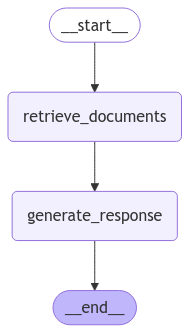

In [19]:
from IPython.display import Image, display

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

### Graph Invocation

Now that our graph is defined, let's invoke it!

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol. This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.

The input is a dictionary `{"question": "Does LangGraph work with OSS LLMs"}`, which sets the initial value for our graph state dict. Note that we didn't need to pass in all of the keys of our dictionary.

Our graph executes as follows:
1. When `invoke` is called, the graph starts execution from the `START` node.
2. It progresses to `retrieve_documents` and invokes our retriever on the `question` defined in our State. It then writes the retrieved `documents` to State.
3. It progresses to `generate_response` and makes an LLM call to generate an answer, using our retrieved `documents`.
4. Finally, it progresses to the `END` node.

Each node function receives the current state and returns a new value, which overrides the graph state.

In [ ]:
question = "Does LangGraph work with OSS LLMs?"
simple_rag_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---


Congrats on running your first LangGraph application!

`invoke` runs the entire graph synchronously. This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed, which is what we see above.

__Let's take a look in LangSmith__

__Let's take a look in LangGraph Studio__